# Анализ и проверка гипотез сервиса аренды самокатов

Анализ данных и проверка гипотез о пользователях и поездках сервиса аренды самокатов GoFast.

Данные представлены тремя датафреймами в формате CSV: users_go, rides_go, subscriptions_go. Первый хранит информацию о каждом пользователе (его id, имя, возраст, город, тип подписки). Во втором содержатся данные о дате, длительности и дистанции каждой поездки. Третий хранит информацию о стоимости услуг для каждого типа подписки. 

Цель исследования: анализ данных и проверка гипотез, которые могут помочь бизнесу вырасти.

План исследования: 
1. Загрузка данных
2. Предобработка данных
3. Исследовательский анализ данных
4. Объединение данных
5. Подсчет выручки
6. Проверка гипотез
7. Работа с распределениями

## Загрузка данных 

Импортируем необходимые для дальнейшей работы библиотеки.

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('dark')
import numpy as np
from scipy import stats as st
from scipy.stats import binom
from math import factorial

Сохраним CSV-файлы в датафреймы pandas.

In [7]:
#данные о пользователях
url_id = '1M7rOZvWsF09No1QiYUJQVLDp_ZlkkjXT'
url = 'https://drive.google.com/uc?id=' + url_id
users = pd.read_csv(url)
#данные о поездках
url_id = '1t0lHm09LKO3Eo29bKhkaD_blM4osqygF'
url = 'https://drive.google.com/uc?id=' + url_id
rides = pd.read_csv(url)
#данные о подписках
url_id = '1XDd5a_EzHh2eOvKPv-wUeB3CxvojR8sD'
url = 'https://drive.google.com/uc?id=' + url_id
subs = pd.read_csv(url)

Посмотрим общую информацию о датафреймах.

In [9]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1565 entries, 0 to 1564
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   user_id            1565 non-null   int64 
 1   name               1565 non-null   object
 2   age                1565 non-null   int64 
 3   city               1565 non-null   object
 4   subscription_type  1565 non-null   object
dtypes: int64(2), object(3)
memory usage: 61.3+ KB


В таблице с данными о пользователях 1565 записей. Пропусков нет. Типы данных в каждом столбце соответствуют содержимому.

In [11]:
rides.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   user_id   18068 non-null  int64  
 1   distance  18068 non-null  float64
 2   duration  18068 non-null  float64
 3   date      18068 non-null  object 
dtypes: float64(2), int64(1), object(1)
memory usage: 564.8+ KB


В таблице с данными о поездках 18068 записей. Пропусков нет. Столбец с информацией о датах поездок представлен текстовым типом данных, необходимо в дальнейшем заменить на "datetime".

In [13]:
subs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2 entries, 0 to 1
Data columns (total 4 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   subscription_type  2 non-null      object
 1   minute_price       2 non-null      int64 
 2   start_ride_price   2 non-null      int64 
 3   subscription_fee   2 non-null      int64 
dtypes: int64(3), object(1)
memory usage: 196.0+ bytes


В таблице с данными о подписках всего 2 записи. Пропусков нет. Необходимости менять тип данных тоже нет.

Выведем на экран несколько строк из каждого датафрейма.

In [16]:
users.head()

,user_id,name,age,city,subscription_type
0,1,Кира,22,Тюмень,ultra
1,2,Станислав,31,Омск,ultra
2,3,Алексей,20,Москва,ultra
3,4,Константин,26,Ростов-на-Дону,ultra
4,5,Адель,28,Омск,ultra


In [17]:
rides.head()

,user_id,distance,duration,date
0,1,4409.919140,25.599769,2021-01-01
1,1,2617.592153,15.816871,2021-01-18
2,1,754.159807,6.232113,2021-04-20
3,1,2694.783254,18.511000,2021-08-11
4,1,4028.687306,26.265803,2021-08-28


In [18]:
subs.head()

,subscription_type,minute_price,start_ride_price,subscription_fee
0,free,8,50,0
1,ultra,6,0,199


Данные загружены. Готовы к предобработке.

## Предобработка данных

### Изменение типов данных

Приведем столбец с датами поездок к соответствующему типу.

In [23]:
rides['date'] = rides['date'].astype('datetime64[ns]')

Создадим в таблице rides новый столбец с номером месяца.

In [25]:
rides['month'] = rides['date'].dt.month

Проверяем получилось ли добавить столбец.

In [27]:
rides.head()

,user_id,distance,duration,date,month
0,1,4409.919140,25.599769,2021-01-01,1
1,1,2617.592153,15.816871,2021-01-18,1
2,1,754.159807,6.232113,2021-04-20,4
3,1,2694.783254,18.511000,2021-08-11,8
4,1,4028.687306,26.265803,2021-08-28,8


Столбец с номером месяца успешно добавлен.

In [29]:
rides['month'].unique()

array([ 1,  4,  8, 10, 11, 12,  3,  6,  7,  2,  5,  9])

Проверим данные за какой период у нас имеются.

In [31]:
print(rides['date'].min())
print(rides['date'].max())

2021-01-01 00:00:00
2021-12-30 00:00:00


Данные представлены периодом с 1 января по 30 декабря 2021 года.

### Обработка дубликатов

Проверим данные на наличие дубликатов. Начнем с явных дубликатов.

In [35]:
users.duplicated().sum()

31

В таблице users 31 дубликат. Удалим их.

In [37]:
print(f'Количество записей в таблице users равно {len(users)}, количество дубликатов в таблице равно {users.duplicated().sum()}.')
print(f'Соответственно количество записей в таблице после удаления дубликатов должно равняться {len(users) - users.duplicated().sum()}')

Количество записей в таблице users равно 1565, количество дубликатов в таблице равно 31.
Соответственно количество записей в таблице после удаления дубликатов должно равняться 1534


In [38]:
#удаляем дубликаты
users = users.drop_duplicates().reset_index(drop = True)

In [39]:
print(f'Количество записей в users после удаления дубликатов составляет {len(users)}')

Количество записей в users после удаления дубликатов составляет 1534


Дубликаты успешно удалены из таблицы users.

Посмотрим дубликаты из датафрейма rides.

In [42]:
rides.duplicated().sum()

0

Явных дубликатов нет.

Таблицу с данными о подписках проверять на дубликаты не будем, т.к. там всего 2 записи. При выводе таблицы на экран выше, можно увидеть, что дубликатов в ней нет.

Проверим столбцы с категориальными данными на неявные дубликаты.

Начнем с данных об именах пользователей.

In [47]:
#приведем данные к нижнему регистру
users['name'] = users['name'].str.lower()
users['name'].unique()

array(['кира', 'станислав', 'алексей', 'константин', 'адель', 'регина',
       'игорь', 'юрий', 'ян', 'валерий', 'агата', 'марк', 'ева',
       'антонина', 'валерия', 'амалия', 'даниил', 'аделина', 'святогор',
       'борис', 'вероника', 'ростислав', 'назар', 'эдуард', 'василий',
       'денис', 'тамара', 'николай', 'эвелина', 'федор', 'руслан', 'иван',
       'любовь', 'ярослава', 'майя', 'ильдар', 'данила', 'нина',
       'стефания', 'ясмина', 'дмитрий', 'александр', 'одиссей', 'арсений',
       'алла', 'таисия', 'максим', 'юлиана', 'павел', 'карина', 'алиса',
       'лидия', 'рамиль', 'родион', 'ника', 'оксана', 'анастасия',
       'маргарита', 'вера', 'тимур', 'никита', 'лев', 'влад', 'артур',
       'анна', 'ольга', 'вячеслав', 'ксения', 'виталина', 'владислав',
       'тамерлан', 'амина', 'вадим', 'олеся', 'зарина', 'егор', 'гордей',
       'лилия', 'святослав', 'роберт', 'амир', 'влада', 'богдан',
       'полина', 'марат', 'елисей', 'макар', 'алина', 'глеб', 'андрей',
       'ал

Дубликатов нет.

Проверим столбец с названиями городов.

In [50]:
users['city'] = users['city'].str.lower()
users['city'].unique()

array(['тюмень', 'омск', 'москва', 'ростов-на-дону', 'краснодар',
       'пятигорск', 'екатеринбург', 'сочи'], dtype=object)

Дубликатов нет.

Проверим данные с типом подписки.

In [53]:
users['subscription_type'].unique()

array(['ultra', 'free'], dtype=object)

Предобработка данных завершена.

В ходе предобработки данных были внесены следующие корректировки: тип данных в столбце с датой и временем был изменен с текстового на "datetime64"; в таблицу rides был добавлен столбец с номером месяца поездки; были удалены дубликаты из датафрейма users, а содержимое столбцов с именами пользователей и названиями городов были приведены к нижнему регистру.

## Исследовательский анализ данных

### Анализ категориальных данных

Визуализируем информацию о частоте встречаемости городов с помощью столбчатой диаграммы.

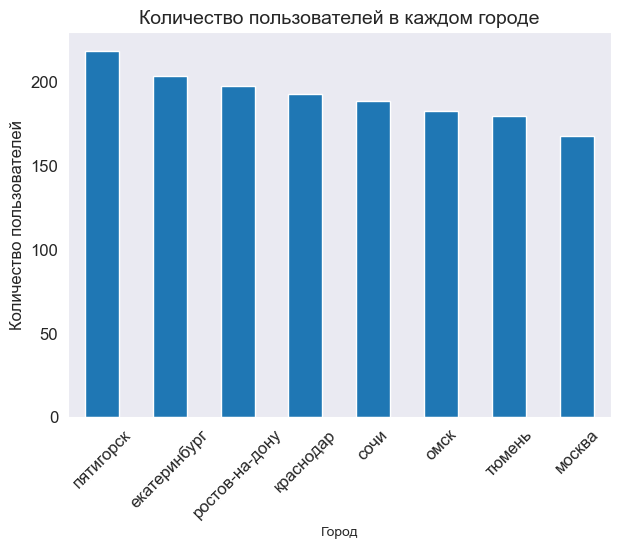

In [58]:
# сгруппируем данные по городам и посчитаем количество пользователей в каждом из них.
# на основе сгрупированных данных строим график
users.groupby('city')['user_id'].count().sort_values(ascending = False).plot(kind = 'bar', figsize = (7,5), fontsize = 12)
plt.xlabel('Город')
plt.ylabel('Количество пользователей', fontsize = 12)
# названия городов написаны вертикально, из-за чего их неудобно читать. Сделаем для удобства текст по диагонали.
plt.tick_params(axis = 'x', rotation = 45)
plt.title('Количество пользователей в каждом городе', fontsize = 14)
plt.show()

Из 8 представленных в датафрейме городов, самым популярным оказался Пятигорск, далее идут Екатеринбург и Ростов-на-Дону. Замыкают восьмерку Омск, Тюмень и Москва.

Визуализируем данные о соотношении пользователей с подпиской и без с помощью круговой диаграммы.

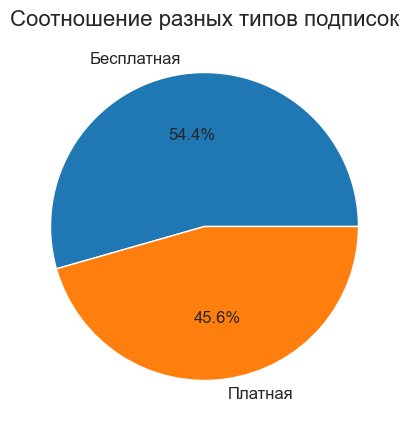

In [187]:
users.groupby('subscription_type')['user_id'].count().plot(kind = 'pie', figsize = (5,5), labels = ['Бесплатная', 'Платная'], autopct = '%1.1f%%', fontsize = 12)
plt.ylabel('')
plt.title('Соотношение разных типов подписок', fontsize = 16)
plt.show()

54,4% пользователей используют бесплатную подписку, 45,6% - платную.

### Анализ числовых данных

Визуализируем данные о возрасте пользователей с помощью гистограммы.

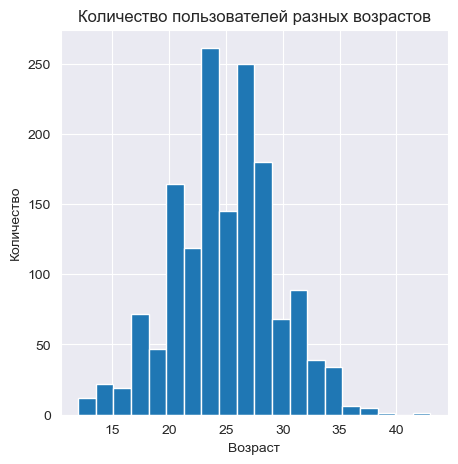

In [64]:
users['age'].hist(bins = 20, figsize = (5,5))
plt.xlabel('Возраст')
plt.ylabel('Количество')
plt.title('Количество пользователей разных возрастов')
plt.show()

Как мы видим из графика, сервисом пользуются люди возрастом от ~10 лет до 40+ лет. Наиболее популярен сервис у пользователей 20-30 лет.

Посмотрим данные о расстояниях, которые преодолевают пользователи за одну поездку с помощью гистрограммы.

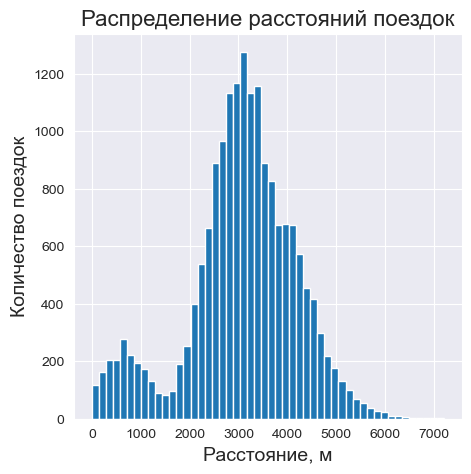

In [67]:
rides['distance'].hist(bins = 50, figsize = (5,5))
plt.xlabel('Расстояние, м', fontsize = 14)
plt.ylabel('Количество поездок', fontsize = 14)
plt.title ('Распределение расстояний поездок', fontsize = 16)
plt.show()

Мы видим на гистограмме 2 пика распределения. Один большой в районе ~3000 м, другой - маленький, в районе ~500 метров. Первый пик скорее всего связан с короткими поездками до станций метро и остановок общественного транспорта

Посмотрим распределение времени, которое тратят пользователи на поездки

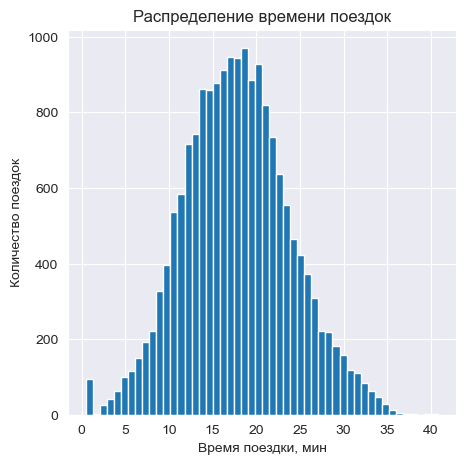

In [70]:
rides['duration'].hist(bins = 50, figsize = (5,5))
plt.xlabel('Время поездки, мин')
plt.ylabel('Количество поездок')
plt.title ('Распределение времени поездок')
plt.show()

Время поездок нормально распределено с центром в районе ~17 минут. В районе нуля наблюдаем пик. Рассмотрим его поближе. 

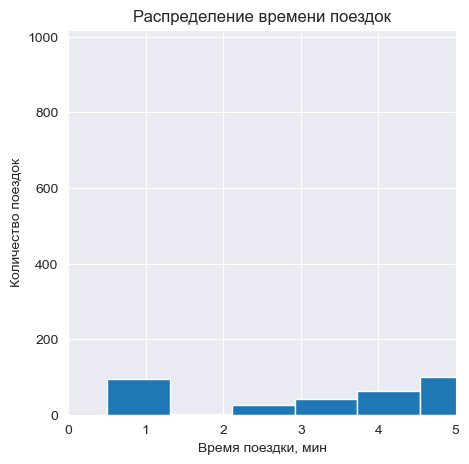

In [72]:
rides['duration'].hist(bins = 50, figsize = (5,5))
#ограничим гистограмму временем от 0 до 5 минут
plt.xlim(0,5)
plt.xlabel('Время поездки, мин')
plt.ylabel('Количество поездок')
plt.title ('Распределение времени поездок')
plt.show()

Пик приходится в районе одной минуты. Рассмотрим эти данные.

In [74]:
rides.query('duration <=1')

,user_id,distance,duration,date,month
6531,701,4196.445201,0.5,2021-08-31,8
6570,704,4830.824371,0.5,2021-10-14,10
6680,712,4684.004397,0.5,2021-03-04,3
6695,713,5215.642710,0.5,2021-02-25,2
6768,718,5197.436649,0.5,2021-02-11,2
...,...,...,...,...,...
17004,1460,5531.335845,0.5,2021-01-19,1
17242,1477,6724.932981,0.5,2021-01-12,1
17314,1483,4445.481070,0.5,2021-03-06,3
17505,1496,5722.551787,0.5,2021-02-14,2


In [75]:
rides.query('duration <=1')['duration'].value_counts()

duration
0.5    95
Name: count, dtype: int64

95 записей со временем 0.5 минут, но при этом на срезе выше мы видим большое расстояние этих поездок.
Возможно здесь по ошибке записали 0.5 часов, проверим это.

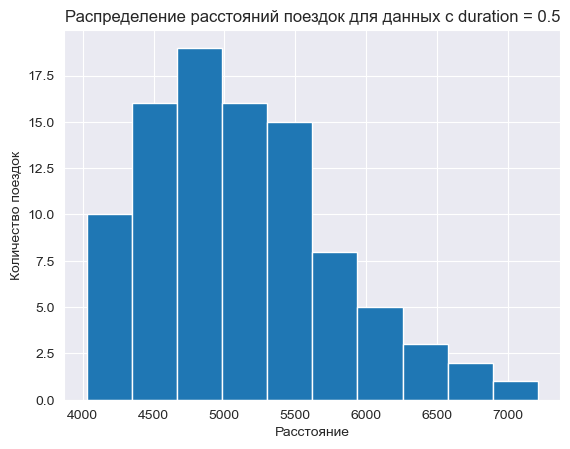

In [77]:
# распределение расстояний поездок в срезе
rides.query('duration <=1')['distance'].hist()
plt.xlabel('Расстояние')
plt.ylabel('Количество поездок')
plt.title('Распределение расcтояний поездок для данных с duration = 0.5')
plt.show()

Длительность поездок в срезе довольно длительная, от 4000 до 7000 м.

Рассмотрим как распределены длительности поездок для таких расстояний для всего датафрейма.

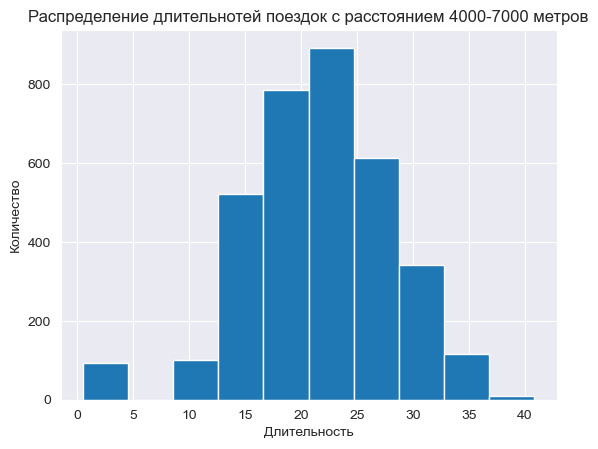

In [80]:
rides.query('7000 >= distance >= 4000')['duration'].hist() # срез поездок с расстоянием 4000-7000 метров
plt.xlabel('Длительность')
plt.ylabel('Количество')
plt.title('Распределение длительностей поездок с расстоянием 4000-7000 метров')
plt.show()

Похоже на то, что под "0.5" имелось ввиду "0.5" часов, т.к. поездки на такие расстояния действительно занимают примерно такую длительность.

Изменим значения "0.5" на количество минут. Для точности, можно заполнить длительность в зависимости от расстояния. Для этого сначала рассмотрим есть ли зависимость между временем поездки и длительностью.

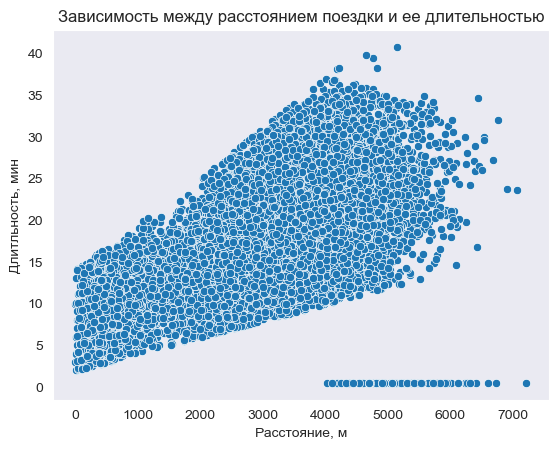

In [83]:
sns.scatterplot(data = rides, x = 'distance', y = 'duration')
plt.xlabel('Расстояние, м')
plt.ylabel('Длитльность, мин')
plt.title('Зависимость между расстоянием поездки и ее длительностью')
plt.show()

На графике видна прямая корреляция расстояния и длительности. В нижне правом углу видны значения, которые мы собираемся заменить. 

Заменим значения "0.5" для расстояния 4000-4500 м медианным значением для данного расстояния, для 4500-5000 м медианным значением для данного расстояния и т.д.

In [86]:
distances = np.arange(4000,8000,500)
for d in distances:
    rides.loc[(rides['distance']>=d) & (rides['distance']<d+500) & (rides['duration'] == 0.5), 'duration']\
= rides.loc[(rides['distance']>d) & (rides['distance']<d+500), 'duration'].median()

Визуализируем работу функции

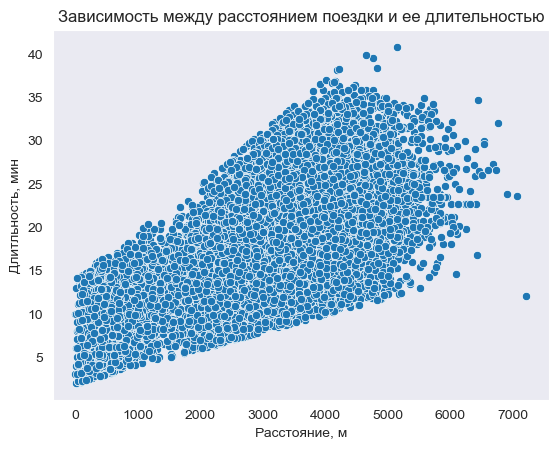

In [88]:
sns.scatterplot(data = rides, x = 'distance', y = 'duration')
plt.xlabel('Расстояние, м')
plt.ylabel('Длитльность, мин')
plt.title('Зависимость между расстоянием поездки и ее длительностью')
plt.show()

Аномальные значения изменены.

В ходе исследовательского анализа данных определили пользователи из каких городов преобладают на сервисе, долю пользователей  подпиской, посмотрели распределение возрастов, расстояний и длительностей поездок. В поле с длительностью поездок обнаружены аномальные данные которые были заменены.

## Объединение данных

### Работа с таблицами

Необходимо объеденить 3 датафрейма в один. Для начала объединим датафреймы users и rides. Затем к объединенному датафрему присоединим таблицу subs.

In [92]:
df = users.merge(rides, on = 'user_id')
df = df.merge(subs, on = 'subscription_type')

Проверяем полученный датафрейм.

In [94]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18068 entries, 0 to 18067
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            18068 non-null  int64         
 1   name               18068 non-null  object        
 2   age                18068 non-null  int64         
 3   city               18068 non-null  object        
 4   subscription_type  18068 non-null  object        
 5   distance           18068 non-null  float64       
 6   duration           18068 non-null  float64       
 7   date               18068 non-null  datetime64[ns]
 8   month              18068 non-null  int32         
 9   minute_price       18068 non-null  int64         
 10  start_ride_price   18068 non-null  int64         
 11  subscription_fee   18068 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int32(1), int64(5), object(3)
memory usage: 1.6+ MB


,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,кира,22,тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,кира,22,тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,кира,22,тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,кира,22,тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,кира,22,тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199


Таблицы объединены. Данные не потеряны.

Далее необходимо разделить полученный датафрейм на 2 отдельных. Один для пользователей с подпиской, другой - без.

In [97]:
df_ultra = df.query('subscription_type == "ultra"')
df_free = df.query('subscription_type == "free"')

Проверим получившиеся таблицы.

In [99]:
df_ultra.info()
df_ultra.head()

<class 'pandas.core.frame.DataFrame'>
Index: 6500 entries, 0 to 6499
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            6500 non-null   int64         
 1   name               6500 non-null   object        
 2   age                6500 non-null   int64         
 3   city               6500 non-null   object        
 4   subscription_type  6500 non-null   object        
 5   distance           6500 non-null   float64       
 6   duration           6500 non-null   float64       
 7   date               6500 non-null   datetime64[ns]
 8   month              6500 non-null   int32         
 9   minute_price       6500 non-null   int64         
 10  start_ride_price   6500 non-null   int64         
 11  subscription_fee   6500 non-null   int64         
dtypes: datetime64[ns](1), float64(2), int32(1), int64(5), object(3)
memory usage: 634.8+ KB


,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
0,1,кира,22,тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199
1,1,кира,22,тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199
2,1,кира,22,тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199
3,1,кира,22,тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199
4,1,кира,22,тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199


In [100]:
df_free.info()
df_free.head()

<class 'pandas.core.frame.DataFrame'>
Index: 11568 entries, 6500 to 18067
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   user_id            11568 non-null  int64         
 1   name               11568 non-null  object        
 2   age                11568 non-null  int64         
 3   city               11568 non-null  object        
 4   subscription_type  11568 non-null  object        
 5   distance           11568 non-null  float64       
 6   duration           11568 non-null  float64       
 7   date               11568 non-null  datetime64[ns]
 8   month              11568 non-null  int32         
 9   minute_price       11568 non-null  int64         
 10  start_ride_price   11568 non-null  int64         
 11  subscription_fee   11568 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int32(1), int64(5), object(3)
memory usage: 1.1+ MB


,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee
6500,700,айдар,22,омск,free,2515.690719,14.944286,2021-01-02,1,8,50,0
6501,700,айдар,22,омск,free,846.932642,16.234663,2021-02-01,2,8,50,0
6502,700,айдар,22,омск,free,4004.434142,20.016628,2021-02-04,2,8,50,0
6503,700,айдар,22,омск,free,1205.911290,9.782872,2021-02-10,2,8,50,0
6504,700,айдар,22,омск,free,3047.379435,17.427673,2021-02-14,2,8,50,0


In [101]:
print(f'Размер датафрейма df - {len(df)} строк. В датафреймах df_users и df_free в сумме {len(df_free)+len(df_ultra)} строк.')
print(f'Соответственно разделение таблиц прошло без потери данных.')

Размер датафрейма df - 18068 строк. В датафреймах df_users и df_free в сумме 18068 строк.
Соответственно разделение таблиц прошло без потери данных.


### Визуализация данных

Визуализируем данные о расстоянии для пользователей без подписки.

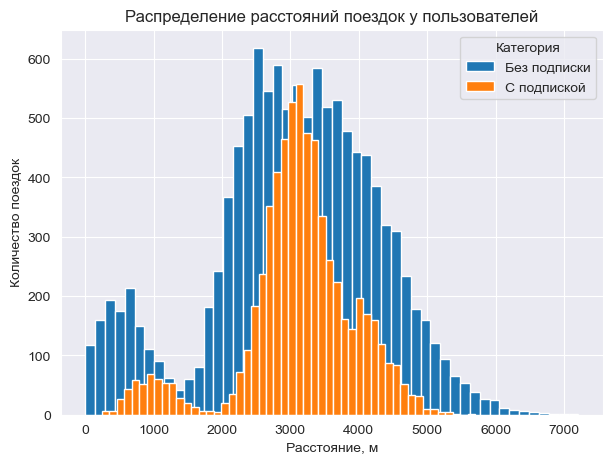

In [103]:
ax = df_free['distance'].hist(bins = 50, figsize = (7,5))
df_ultra['distance'].hist(ax=ax, bins = 50, figsize = (7,5))
plt.xlabel('Расстояние, м')
plt.ylabel('Количество поездок')
plt.title ('Распределение расстояний поездок у пользователей')
plt.legend(title = 'Категория',labels = ['Без подписки','C подпиской'])
plt.show()

У обоих групп пользователей распределение выглядит примерно так же, как и до разделения. На обоих гистограммах видно будто 2 нормальных распределения в одном, и на обоих самый большой пик в районе 3000 метров. Однако пик слева для пользователей без подписки составляет примерно 500 м, а для пользователей с подпиской - 1000 метров.

Визуализируем информацию о времени поездок для обоих групп пользователей.

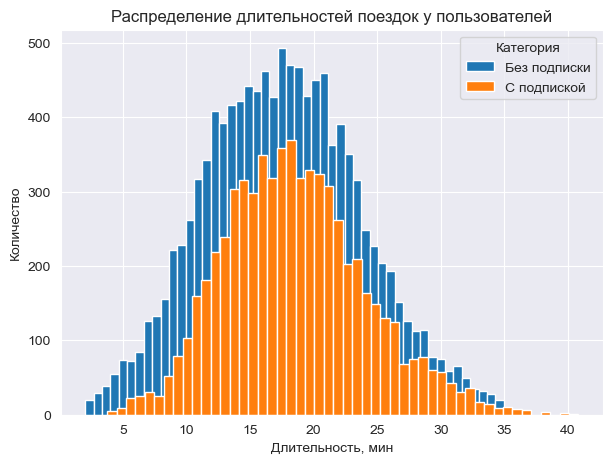

In [106]:
ax = df_free['duration'].hist(bins = 50, figsize = (7,5))
df_ultra['duration'].hist(ax=ax, bins = 50, figsize = (7,5))
plt.xlabel('Длительность, мин')
plt.ylabel('Количество')
plt.legend(title = 'Категория', labels = ['Без подписки','С подпиской'])
plt.title('Распределение длительностей поездок у пользователей')
plt.show()

У обоих групп пользователей гистограмма представлена нормальным распределением с центром в районе 17 минут. Однако у платных пользователей длительность поездок некоторых пользователей доходит до 40+ минут, в отличии от 35 минут у пользователей без подписки.

## Подсчёт выручки

Создадим аггрегированный датафрейм с данными о расстоянии, длительности и количестве поездок для каждого пользователя в каждом месяце.
Для этого создадим 2 сводные таблицы. В одной будут агреггированные данные о расстоянии и длительности, в другой - о количестве поездок. Затем мы соединим 2 таблицы.

Перед созданием сводной таблицы округлим данные о длительности поездок в исходном датафрейме до следующего целого чиcла

In [112]:
# сохраним округленные данные в новом столбце исходного датафрейма
df['duration_rounded'] = np.ceil(df['duration'])

In [113]:
# посмотрим работу функции
df.head()

,user_id,name,age,city,subscription_type,distance,duration,date,month,minute_price,start_ride_price,subscription_fee,duration_rounded
0,1,кира,22,тюмень,ultra,4409.919140,25.599769,2021-01-01,1,6,0,199,26.0
1,1,кира,22,тюмень,ultra,2617.592153,15.816871,2021-01-18,1,6,0,199,16.0
2,1,кира,22,тюмень,ultra,754.159807,6.232113,2021-04-20,4,6,0,199,7.0
3,1,кира,22,тюмень,ultra,2694.783254,18.511000,2021-08-11,8,6,0,199,19.0
4,1,кира,22,тюмень,ultra,4028.687306,26.265803,2021-08-28,8,6,0,199,27.0


Данные успешно округлены

In [115]:
# сводная таблица с информацией о длительности и расстоянии поездок каждого пользоватлеля в каждом месяце
df_user_by_month1 = df.pivot_table (index = ['user_id','month'], values = ['distance','duration_rounded'], aggfunc = 'sum')
df_user_by_month1

distance  duration_rounded
user_id month                                
1       1       7027.511294              42.0
        4        754.159807               7.0
        8       6723.470560              46.0
        10      5809.911100              32.0
        11      7003.499363              56.0
...                     ...               ...
1534    6       3409.468534              26.0
        8       7622.453034              48.0
        9       4928.173852              23.0
        11     13350.015305              78.0
        12      2371.711192              16.0

[11331 rows x 2 columns]

In [116]:
# сводная таблица с количеством поездок для каждого пользователя в каждом месяце
df_user_by_month2 = df.pivot_table (index = ['user_id','month'], values = 'distance', aggfunc = 'count')
# переименуем столбец с количеством поездок, т.к. метод .join() не позволит нам соединить таблицы,
# если в обоих будет столбец с названием "distance"
df_user_by_month2 = df_user_by_month2.rename(columns = {'distance':'rides'})
df_user_by_month2

rides
user_id month       
1       1          2
        4          1
        8          2
        10         2
        11         3
...              ...
1534    6          2
        8          2
        9          1
        11         4
        12         1

[11331 rows x 1 columns]

In [117]:
# соединяем таблицы
df_user_by_month = df_user_by_month1.join(df_user_by_month2)
df_user_by_month = df_user_by_month.reset_index()
df_user_by_month

,user_id,month,distance,duration_rounded,rides
0,1,1,7027.511294,42.0,2
1,1,4,754.159807,7.0,1
2,1,8,6723.470560,46.0,2
3,1,10,5809.911100,32.0,2
4,1,11,7003.499363,56.0,3
...,...,...,...,...,...
11326,1534,6,3409.468534,26.0,2
11327,1534,8,7622.453034,48.0,2
11328,1534,9,4928.173852,23.0,1
11329,1534,11,13350.015305,78.0,4


Мы получили таблицу с агреггированными данными о суммарном расстоянии, времени и количестве поездок для каждого пользователя в каждом месяце.

Нам необходимо добавить столбец с помесячной выручкой от каждого пользователя. 
Подсчет выручки отличается в зависимости от типа подписки, это нужно учитывать при расчетах.

Создадим датафрейм, который хранит тип подписки каждого пользователя.

In [121]:
users_and_types = users[['user_id','subscription_type']]
users_and_types

,user_id,subscription_type
0,1,ultra
1,2,ultra
2,3,ultra
3,4,ultra
4,5,ultra
...,...,...
1529,1530,free
1530,1531,free
1531,1532,free
1532,1533,free


Соединим его с агреггированным датафреймом.

In [123]:
df_user_by_month = df_user_by_month.merge(users_and_types, on = 'user_id')
df_user_by_month

,user_id,month,distance,duration_rounded,rides,subscription_type
0,1,1,7027.511294,42.0,2,ultra
1,1,4,754.159807,7.0,1,ultra
2,1,8,6723.470560,46.0,2,ultra
3,1,10,5809.911100,32.0,2,ultra
4,1,11,7003.499363,56.0,3,ultra
...,...,...,...,...,...,...
11326,1534,6,3409.468534,26.0,2,free
11327,1534,8,7622.453034,48.0,2,free
11328,1534,9,4928.173852,23.0,1,free
11329,1534,11,13350.015305,78.0,4,free


Теперь в таблице df_user_by_month есть информация о типе подписки каждого пользователя. Исходя из этого, а также из данных о количестве поездок и расстоянии, которое каждый пользователь преодолел за месяц, можно посчитать ежемесячную выручку.

In [125]:
# создаем функцию, которая при наличии у пользователя подписки, суммирует абонентскую плату и произведение длительности 
# на стоимость 1 минуты, а при отсутсвии подписки суммирует произведение количества поездок на стоимость старта и произведение
# длительности на стоимость 1 минуты

def counting_revenue(row):
    duration = row['duration_rounded']
    rides = row['rides']
    sub_type = row['subscription_type']
    if sub_type == 'ultra':
        return 199 + duration*6
    else: 
# стоимость минуты без подписки составляет 8 рублей, а не 6
        return rides*50 + duration*8

In [126]:
# применяем функцию
df_user_by_month['revenue'] = df_user_by_month.apply(counting_revenue, axis = 1)
df_user_by_month

,user_id,month,distance,duration_rounded,rides,subscription_type,revenue
0,1,1,7027.511294,42.0,2,ultra,451.0
1,1,4,754.159807,7.0,1,ultra,241.0
2,1,8,6723.470560,46.0,2,ultra,475.0
3,1,10,5809.911100,32.0,2,ultra,391.0
4,1,11,7003.499363,56.0,3,ultra,535.0
...,...,...,...,...,...,...,...
11326,1534,6,3409.468534,26.0,2,free,308.0
11327,1534,8,7622.453034,48.0,2,free,484.0
11328,1534,9,4928.173852,23.0,1,free,234.0
11329,1534,11,13350.015305,78.0,4,free,824.0


Готово. Мы получили столбец с прибылью от каждого пользователя в каждом месяце.

## Проверка гипотез

### Гипотеза о равенстве среднего времени поездки

Проверим гипотезу о том, что пользователи с подпиской тратят больше времени на поездки.
Это пример гипотезы о равенстве средних двух генеральных совокупностей. Можно использовать в качестве проверки статистический тест с использованием t-распределения Стьюдента (t-тест), однако чтобы его применить, выборки должны соответствовать нескольким критериям.

1. Независимость выборок
2. Распределения должны быть нормальными
3. Отсутствие выбросов

Также перед проведением теста нужно проверить размер выборок и их дисперсии для параметра "equal_var".

Значения выборок не зависят друг от друга во времени, соответствнно они независимы. Распределения являются нормальными и выбросов нет (визуализировали в пункте 4), соответственно выборки пригодны для проведения t-теста.

Проверим количество значений в каждой выборке.

In [133]:
print(f'Количество значений в выборке с подпиской: {len(df_ultra['duration'])}, без подписки - {len(df_free['duration'])}')
print(f'Дисперсия в выборке с подпиской равна {round(df_ultra['duration'].var(),2)}, в выборке без подписки - {round(df_free['duration'].var(),2)}')

Количество значений в выборке с подпиской: 6500, без подписки - 11568
Дисперсия в выборке с подпиской равна 31.05, в выборке без подписки - 37.89


Количество значений в выборках заметно отличается, при проведении теста в параметрах нужно будет указать "equal_var = False"

СФормулируем гипотезы


Нулевая гипотеза: пользователи с подпиской тратят в среднем столько же времени на поездки, сколько пользователи без подписки.

Альтернативная гипотеза: пользователи с подпиской тратят на поездки больше времени.

In [136]:
# устанавливаем уровень статистической значимости в 5%
alpha = 0.05
# устанавливаем параметр equal_var = False, т.к. размеры выборок разные. В параметре "alternative"
# указываем "greater", т.к. альтернативная теория правостороняя
results = st.ttest_ind(df_ultra['duration'],df_free['duration'], equal_var = False, alternative = 'greater')
print(f'p-value равно {results.pvalue}')
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-value равно 2.0071546728645324e-27
Отвергаем нулевую гипотезу


Гипотезу о равенстве времени поездок для двух групп пользователей отвергаем. Похоже на то, что пользователи с подпиской действительно в среднем больше тратят времени на поездки.

### Гипотеза о равенстве среднего расстояния поездки некоторому числу

Проверим гипотезу о том, что среднее расстояние, которое проезжают пользователи с подпиской, не превышает 3130 метров.
Это пример односторонней гипотезы о равенстве среднего генеральной совокупности некоторому значению.

Данные в выборке независимы.

Для данного теста выборка должна быть нормально распределена. Она уже была визуализирована в пункте 4. На ней можно видеть 2 пика, но поскольку в выборке достаточное количество значений, это не должно быть препятствием благодаря центральной предельной теореме.

Выбросы в выборке также отсутствуют.

In [141]:
print(f'Количество значений в выборке: {len(df_ultra['distance'])}')

Количество значений в выборке: 6500


Сформулируем гипотезы

Нулевая гипотеза: среднее расстояние, которую проезжает пользователь с подпиской, меньше или равна 3130 метрам.

Альтернативная гипотеза: среднее расстояние превышает 3130 метров.

In [143]:
alpha = 0.05
results = st.ttest_1samp(df_ultra['distance'], 3130, alternative = 'greater')
print(f'p-value равно {results.pvalue}')
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-value равно 0.9195368847849785
Нет оснований отвергнуть нулевую гипотезу


Гипотеза о том, что платящие пользователи в среднем преодолевают расстояние меньшее или равное 3130 метрам, вполне правдоподобно. Мы ее не отвергаем (но и не подтверждаем).

### Гипотеза о равенстве помесячной выручки

Проверим гипотезу о том, будет ли помесячная выручка от пользователей с подпиской по месяцам выше, чем выручка от пользователей без подписки. Это пример односторонней гипотезы о равенстве средних 2-х генеральных совокупностей.

Сформируем выборки и проверим распределения.

In [148]:
# сохраним данные о помесячной выручке каждой группы в отдельные переменные
ultra_revenue = df_user_by_month.query('subscription_type == "ultra"')['revenue']
free_revenue = df_user_by_month.query('subscription_type == "free"')['revenue']

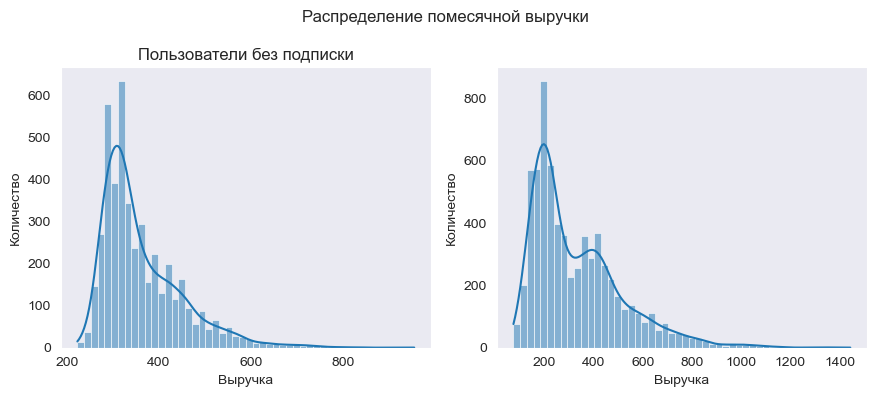

In [149]:
fig, axs = plt.subplots(1,2,figsize = (9,4) )
sns.histplot(data = ultra_revenue, ax = axs[0], bins = 50, kde = True)
sns.histplot(data = free_revenue, ax = axs[1], bins = 50, kde = True)
for ax in axs.flat:
    ax.set(xlabel = 'Выручка', ylabel = 'Количество')
axs[0].set_title('Пользователи с подпиской')
axs[0].set_title('Пользователи без подписки')  
fig.suptitle('Распределение помесячной выручки')
plt.tight_layout()
plt.show()

В выборках есть выбросы. Нужно их отфильтровать. Посмотрим на 95, 97,5 и 99-й перцентили обоих выборок.

In [151]:
print(np.percentile(ultra_revenue,[95,97.5,99]))
print(np.percentile(free_revenue,[95,97.5,99]))

[541.   583.   671.08]
[694. 792. 944.]


Отфильтруем обе выборки по 97.5 перцентилю.

In [153]:
ultra_revenue = ultra_revenue[ultra_revenue <= np.percentile(ultra_revenue,97.5)]
free_revenue = free_revenue[free_revenue <= np.percentile(free_revenue,97.5)]

Визуализируем отфильтрованные выборки.

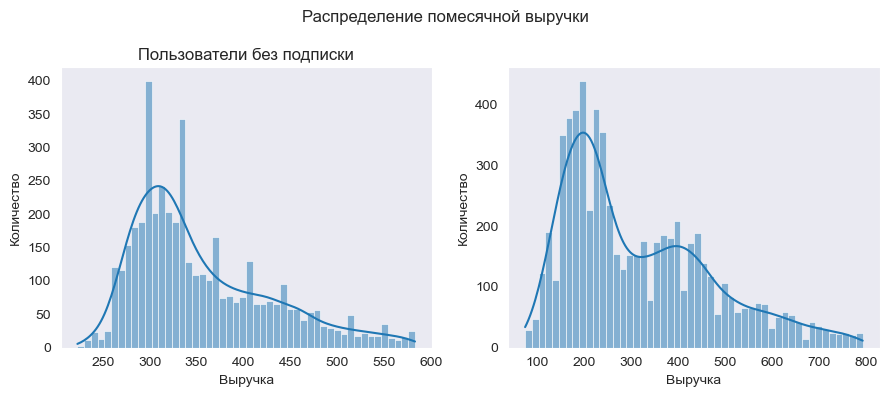

In [166]:
fig, axs = plt.subplots(1,2,figsize = (9,4) )
sns.histplot(data = ultra_revenue, ax = axs[0], bins = 50, kde = True)
sns.histplot(data = free_revenue, ax = axs[1], bins = 50, kde = True)
for ax in axs.flat:
    ax.set(xlabel = 'Выручка', ylabel = 'Количество')
axs[0].set_title('Пользователи с подпиской')
axs[0].set_title('Пользователи без подписки')  
fig.suptitle('Распределение помесячной выручки')
plt.tight_layout()
plt.show()

In [168]:
print(f'Количество значений в выборке ultra_revenue: {len(ultra_revenue)}, дисперсия равна {round(ultra_revenue.var(),2)}')
print(f'Количество значений в выборке free_revenue: {len(free_revenue)}, дисперсия равна {round(free_revenue.var(),2)}')

Количество значений в выборке ultra_revenue: 4422, дисперсия равна 5507.87
Количество значений в выборке free_revenue: 6632, дисперсия равна 25069.43


От выбросов избавились. Выборки не распределены нормально, но значений достаточно, чтобы этим пренебречь.

Поскольку количество значений в выборках значительно отличается друг от друга и выборки имеют разные дисперсии, необходимо использовать параметр "equal_var = False"

In [154]:
alpha = 0.05
results = st.ttest_ind(ultra_revenue,free_revenue,equal_var = False, alternative = 'greater')
print(f'p-value равно {results.pvalue}')
if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
    print('Нет оснований отвергнуть нулевую гипотезу')

p-value равно 7.0417855436068455e-68
Отвергаем нулевую гипотезу


Отвергаем гипотезу о том, что прибыль от подписчиков и неподписчиков равна. Вероятно подписчики более выгодны сервису, как и предполагалось продакт-менеджерами.

## Вывод

В ходе работы была выполнена предобработка исходных данных: удаление дубликатов, добавление новых столбцов и изменение типа данных в некоторых исходных столбцах. 3 исходных файла были объединены в один датафрейм. Сгруппировали данные о расстоянии и длительности поездок каждого пользователя по месяцам. Вычислили помесячную выручку каждого пользователя.

Выяснили, что сервисом пользуются в 8 городах. Наиболее популярный из них - Пятигорск. Платной подпиской обладают 46% пользователей. Средний возраст пользователей составляет 20-30 лет. Среднее время поездки равно 15-20 минут, а среднее расстояние - 3000 метров. Проверили гипотезы о том, что пользователи с подпиской в среднем дольше пользуются самокатом, среднее расстояние их поездки не превышает 3130 метров и они приносят больше прибыли, чем пользователи без подписки. 

Статистический анализ показал, что в представленной выборке пользователи, платящие ежемесячную абонентскую плату за сервис, более выгодны компании, т.к. тратят больше времени на поездки и средняя ежемесячная выручка от них выше, чем от пользователей без платной подписки на сервис.    